## Project2-Part2- SC, AL, NT



In [1]:
import pkg_resources
import subprocess
import sys
import os

REQUIRED = {
  'spacy', 'scikit-learn', 'numpy', 'pandas', 'torch', 
  'pyfunctional', 'textblob', 'seaborn', 'matplotlib', 'torch'
}

installed = {pkg.key for pkg in pkg_resources.working_set}
missing = REQUIRED - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

import numpy as np
import glob
import pandas as pd
from textblob import TextBlob
from typing import List
import seaborn as sns
import matplotlib.pyplot as plt

From the original experimentation (https://arxiv.org/pdf/1809.04444.pdf) we'll use the same train and test split. 

In [2]:
# dataset git repo
if not os.path.exists("hate-speech-dataset"):
  !git clone https://github.com/Vicomtech/hate-speech-dataset.git
    
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /home/tenglina/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /home/tenglina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tenglina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/tenglina/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /home/tenglina/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/tenglina/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [3]:
def get_data(paths: List[str], group: str):
  
    sets = []
    for p in paths:

        with open(p) as f:
            file_id = p.split('/')[-1].split('.')[0]
            sets.append((file_id, f.read(), group))

    return pd.DataFrame(sets, columns=["file_id", "text", "gSet"])

In [4]:
idLabels = pd.read_csv('hate-speech-dataset/annotations_metadata.csv')[["file_id", "label"]]

In [5]:
train_data = get_data(glob.glob('./hate-speech-dataset/sampled_train/*.txt'), 'train')
test_data = get_data(glob.glob('./hate-speech-dataset/sampled_test/*.txt'), 'test')

train_data = train_data.join(idLabels.set_index('file_id'), on='file_id')
test_data = test_data.join(idLabels.set_index('file_id'), on='file_id')

comb_data = train_data.append(test_data).reset_index(drop=True)

# print label distributions
print("Test dataset:")
print(test_data['label'].value_counts())
print("")
print("Train dataset:")
print(train_data['label'].value_counts())
print("")

print("Total datase shape:", comb_data.shape)
comb_data.tail()

Test dataset:
noHate    239
hate      239
Name: label, dtype: int64

Train dataset:
noHate    957
hate      957
Name: label, dtype: int64

Total datase shape: (2392, 4)


,file_id,text,gSet,label
2387,32923728_3,And now this clip suggests they were suffering...,test,hate
2388,33045538_3,Apparently the Jews ca n't take it when the tr...,test,hate
2389,33463853_1,Whether or not one chooses to eat meat is a ve...,test,noHate
2390,33661913_1,the money he is giving away to refugees and th...,test,noHate
2391,33677053_2,Now I get it !,test,noHate


We first extracted the following features to get a better understanding of the data:
1. sentence length
2. word count
3. sentiment (polarity)
4. subjectivity

In [6]:
strSer = comb_data['text'].str
txtBlob = comb_data['text'].apply(lambda s: TextBlob(s))

comb_data['sentence_len'] = strSer.len()
comb_data['word_count'] = strSer.split().apply(lambda ls: len(ls))
comb_data['polarity'] = txtBlob.apply(lambda blob: blob.sentiment.polarity)
comb_data['subjectivity'] = txtBlob.apply(lambda blob: blob.sentiment.subjectivity)

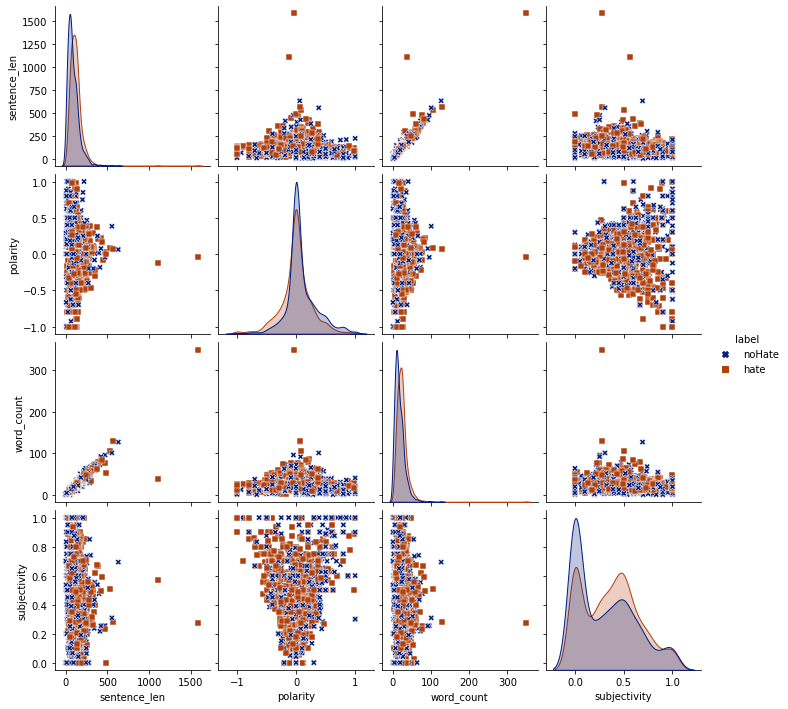

In [7]:
data_plot = comb_data[['sentence_len', 'polarity', 'word_count', 'subjectivity', 'label']]
markers = {"hate": "s", "noHate": "X"}
sns.pairplot(data_plot, hue="label", palette="dark", markers = markers)

As seen from the graphs above, these metrics are not very seperable. Their distributions align on top of each other.

In [8]:
import spacy
from spacy.lang.en.examples import sentences 
from pandas import DataFrame, Series
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from functional import seq
import numpy as np
import pandas as pd
from numpy import log, mean
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import silhouette_score

In [9]:
nlp = spacy.load("en_core_web_sm")

In [10]:
def log_LhArr(src: Series, ref: Series):
    """
    
    """
    src_count: int = src.sum()
    ref_count: int = ref.sum()
  
    agg = (src + ref) / (src_count + ref_count)
    e1 = src_count * agg
    e2 = ref_count * agg

    p1 = src * log(src / e1)
    p2 = ref * log(ref / e2)

    return 2 * (p1 + p2)
  

In [11]:
def LogLikelihoodWrds(docWordMatrix: DataFrame, labels, topN):
    """
    """
    label1, label2 = set(labels)

    aggDf = docWordMatrix.assign(label=labels).groupby('label').sum().T

    aggDf = aggDf.assign(
    l1Diff = aggDf[label1] - aggDf[label2], 
    l2Diff = aggDf[label2] - aggDf[label1],

    llikelihood = log_LhArr(aggDf[label1].replace(0, 0.01), aggDf[label2].replace(0, 0.01))
    )

    label1_i = aggDf['l1Diff'] > 0
    label2_i = aggDf['l1Diff'] < 0

    l1 = aggDf[label1_i].sort_values(by='llikelihood', ascending=False)[:topN]['llikelihood']
    l2 = aggDf[label2_i].sort_values(by='llikelihood', ascending=False)[:topN]['llikelihood']

    print(f"\nTop {label1.upper()} tokens by likelihood:\n")
    print(l1)

    print(f"\nTop {label2.upper()} tokens by likelihood:\n")
    print(l2)

    return (l1, l2)

In [12]:
def hateTokenizer(text: str, spacyModel=nlp):
    
    doc = spacyModel(text)

    return seq(token for token in doc)\
    .filter(lambda t: t.is_alpha)\
    .filter_not(lambda t: t.is_stop)\
    .map(lambda t: t.lemma_.lower())\
    .to_list()

In [13]:
#convert to Data frame
def ToDf(corpus, tokenizer=hateTokenizer, idf=False):
  
    vectorizer = (
    TfidfVectorizer(tokenizer=tokenizer, lowercase=False) 
    if idf else
    CountVectorizer(tokenizer=tokenizer, lowercase=False))
    
    X = vectorizer.fit_transform(corpus)

    return pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())



In [14]:
count_df = ToDf(comb_data['text'])
l1, l2 = LogLikelihoodWrds(count_df, comb_data['label'].tolist(), 10)


Top HATE tokens by likelihood:

black      57.544258
jews       55.029006
negro      41.675687
ape        34.497796
race       24.956010
scum       24.387251
non        20.453671
liberal    20.323862
groid      19.344772
white      19.260670
Name: llikelihood, dtype: float64

Top NOHATE tokens by likelihood:

youtube    34.412715
post       19.923622
meet       18.966872
year       18.157788
pm         17.507563
sf         15.548049
music      13.525243
march      12.065677
link       11.607472
video      11.272354
Name: llikelihood, dtype: float64


In [15]:
models = []

for n in range(2, 9):
    lda = LatentDirichletAllocation(n_components=n, random_state=0)
    lda.fit(count_df)
    models.append((n, lda))

In [16]:
def topWordsPerComponent(componentsMatrix, words=count_df.columns.tolist(), topN: int=10):
    """
    Print top keywords for each component in componentsMatrix.
    componentsMatrix: components matrix from factorization. Shape: (n_topics, tokens_len).
    words: list with words/tokens. Usually the columns of the document-word matrix.
    Length must be equal to *tokens_len* (see parameter above).
    topN: number of words to print per topic.
    """
    df = pd.DataFrame(componentsMatrix.T, index=words)
    cols = [f"topic-{t}" for t in df.columns]

    finalDf = pd.DataFrame([
    df.sort_values(by=col, ascending=False)[:topN].index
    for col in df.columns
    ]).T

    print(finalDf.set_axis(cols, axis=1))

In [18]:
for n, model in models:
    if n > 5:
        break
    
    print("\n", f"Top Keywords With {n} Topics:", "\n")
    topWordsPerComponent(model.components_)


 Top Keywords With 2 Topics: 

   topic-0 topic-1
0    white    like
1    black    year
2   people      go
3     like       m
4     race     new
5    think  people
6     good   black
7     know     not
8  country  school
9    negro    time

 Top Keywords With 3 Topics: 

   topic-0 topic-1 topic-2
0    white    like   white
1    think  school   black
2     like     new    know
3     good  people  people
4     race    time    live
5    black    jews     not
6      non      go    year
7   people     try    look
8    negro       m    like
9  country     jew    find

 Top Keywords With 4 Topics: 

   topic-0 topic-1 topic-2 topic-3
0    white    like   white   white
1    think  people   black    hope
2    black    jews    know    come
3     like   white     not    like
4      kid    time  people     day
5     good     try    find  people
6     race    tell    live    race
7  country     new    year   negro
8   people  school      go    hear
9     want      go   woman     let

 Top Keyword

In [19]:
hateText = comb_data[comb_data['label'] == 'hate']['text'].str.lower()
docs = list(nlp.pipe(hateText, disable=["ner", "textcat"]))

In [20]:
nouns = set([token.lemma_ 
  for doc in docs
  for token in doc
  if token.dep_ == 'nsubj' and not token.is_stop and len(token) > 2
])

pairs = [(hateText.str.contains(nn).sum(), nn) for nn in nouns]
targetsDf = pd.DataFrame(pairs, columns=["sentence_count", "target"])

In [21]:
def cleanDfText(df, col_remove='target', col_sort='sentence_count', show=20):
    """
    Datafram without a particular word from col_remove is printed 
    """
    newDf = df.copy()
    removed = list()
  
    while True:
        word = input("Word to remove (enter 'q' to exit):")

        if word == 'q':
            return removed, newDf

        newDf = newDf[newDf[col_remove] != word]\
                  .sort_values(by=col_sort, ascending=False)\
                  .reset_index(drop=True)
    
        removed.append(word)
        clear_output(wait=True)
        print(newDf.head(show))
    
        # clear notebook I/O
        In.clear()
        Out.clear()

In [22]:
toRemove = ['er','lack','one','use','man','ted','people','way','race',
 'red','cause','non','ape','rat','time','son','country','don','thing',
 'school','world','child','hate','work','kid','lie','nation','scum','hell','mud',
 'filth','human','sex','house','being','car','arm','place','crime','guy',
 'crap','breed','news','town','male'
]

targetsDf[~targetsDf['target'].str.contains("|".join(toRemove))]\
  .sort_values(by="sentence_count", ascending=False)\
  .reset_index(drop=True).head(15)

,sentence_count,target
0,566,ing
1,295,white
2,127,jew
3,94,negro
4,63,jews
5,51,let
6,47,africa
7,43,good
8,38,nig
9,37,asian


In [23]:
#using BERT to perform Binary Classification
import pkg_resources
import subprocess
import pickle
import shutil
import time
import sys
import os

from enum import Enum
from functools import partial

REQUIRED = {
  'spacy', 'scikit-learn', 'numpy', 'pandas', 'torch', 'transformers'
}

installed = {pkg.key for pkg in pkg_resources.working_set}
missing = REQUIRED - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

from typing import List, Dict, Tuple
import glob


import torch
from torch import torch
from torch.utils.data import Dataset
from torch import nn

from dataclasses import dataclass

from sklearn.metrics import accuracy_score


from transformers import PreTrainedTokenizer, PreTrainedModel
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification



import numpy as np
import pandas as pd
from pandas import DataFrame


from transformers import DistilBertModel, DistilBertPreTrainedModel
from transformers import Trainer, TrainingArguments




from transformers import EvalPrediction

ImportError: cannot import name 'torch' from 'torch' (unknown location)

In [140]:
def readData(paths: List[str], group: str):
    pairs = []
    for p in paths:
    
        with open(p) as f:
            file_id = p.split('/')[-1].split('.')[0]
            pairs.append((file_id, f.read(), group))
  
    return pd.DataFrame(pairs, columns=["file_id", "text", "gSet"])

idLabels = pd.read_csv('hate-speech-dataset/annotations_metadata.csv')[["file_id", "label"]]

trainDf = readData(glob.glob('./hate-speech-dataset/sampled_train/*.txt'), 'train')
testDf = readData(glob.glob('./hate-speech-dataset/sampled_test/*.txt'), 'test')

trainDf = trainDf.join(idLabels.set_index('file_id'), on='file_id')
testDf = testDf.join(idLabels.set_index('file_id'), on='file_id')

print(trainDf.info(), '\n')
print(testDf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914 entries, 0 to 1913
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   file_id  1914 non-null   object
 1   text     1914 non-null   object
 2   gSet     1914 non-null   object
 3   label    1914 non-null   object
dtypes: object(4)
memory usage: 59.9+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   file_id  478 non-null    object
 1   text     478 non-null    object
 2   gSet     478 non-null    object
 3   label    478 non-null    object
dtypes: object(4)
memory usage: 15.1+ KB
None


In [110]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
# save original model set of weights. They we'll be used later over multiple iterations
torch.save(model.state_dict(), "./tempBertState.pt")

NameError: name 'DistilBertTokenizer' is not defined

In [ ]:
@dataclass
class TokenizedInput:
    """
    Class for tracking single tokenized inputs 
    (for Pytorch Dataset __getitem__).
    """
    inputs: List[int]
    masks: List[int]
    label: int

    def tokenizedInput(self):
        return (self.inputs, self.masks, self.label)

class HateSpeechDataset(Dataset):
    """
    PyTorch DataSet Class
    """
    
    def __init__(self, corpus: List[str], labels: List[str], tokenizer: PreTrainedTokenizer=tokenizer,truncate=True,padding=True):
        self.tokenizer = tokenizer
        self.trunc = truncate
      
        self.corpusTokenized = tokenizer(corpus, padding=padding)
        self.labels = labels
    
    def __getitem__(self, i):
    inputs = self.corpusTokenized['input_ids'][i]
    masks = self.corpusTokenized['attention_mask'][i]
    
        return TokenizedInput(self._truncate(inputs) if self.trunc else inputs, self._truncate(masks, is_mask=True) if self.trunc else masks,
                      self.labels[i])
    
    
    def __len__(self):
        return len(self.labels)
    
    
    def _truncate(self, vector: List[int], is_mask=False, sep_token_num=102):
    """
    Truncate vector length to model max input size 
    """
        limit = self.tokenizer.max_len
    
        if len(vector) <= limit:
              return vector
        elif is_mask:
              return vector[:limit]
        else:
            last = sep_token_num if vector[-1] not in (0, sep_token_num) else 0
            return vector[:limit - 1] + [last]
  
  


In [ ]:
def collator(items: List[TokenizedInput]) -> Dict:
    """
    converts list of items into a single dictionary
    Used by the Pytorch Dataloader inside the Trainer class
    """
    # keys for DistilBertForSequenceClassification
    input_k = 'input_ids'
    mask_k = 'attention_mask'
    label_k = 'labels'

    # zip input_ids, attention_mask and labels together
    zipped =  list(map(list, zip(*[t.tokenizedInput() for t in items])))
    
    # convert lists to pyTorch tensors
    inputs, masks, labels = list(map(lambda ls: torch.tensor(ls), zipped))

    return {input_k: inputs, mask_k: masks, label_k: labels}


In [ ]:
def prepareDf(df: DataFrame, textCol='text', labelsCol='label'):
    """get columns to be fed to Dataset object"""
    return {"corpus": df[textCol].tolist(), "labels": df[labelsCol].map({'hate': 1, 'noHate': 0})}


In [117]:
def metrics(pred: EvalPrediction):
  
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    mapper = lambda n: True if n == 1 else False

    hatePreds = preds[[mapper(l) for l in labels]]
    noHatePreds = preds[[mapper(l) for l in 1 - labels]]

    return {
      'accHate': accuracy_score(hatePreds, np.ones_like(hatePreds)),
      'accNoHate': accuracy_score(noHatePreds, np.zeros_like(noHatePreds)),
      'accAll': accuracy_score(labels, preds),
  }

NameError: name 'EvalPrediction' is not defined

In [ ]:
#train and test data sets in the correct format

train_dataset = HateSpeechDataset(**prepareDf(trainDf))
test_dataset = HateSpeechDataset(**prepareDf(testDf))
train_ds_mock = HateSpeechDataset(**prepareDf(trainDf[:20]))
test_ds_mock = HateSpeechDataset(**prepareDf(testDf[:20]))

In [ ]:
def trainingArgs(epochs, trainDir, batchSizeTrain=16, batchSizeEval=32,training_set_len=len(train_dataset)):
      """Return a TrainingArguments instance to be passed to Trainer class."""
      # calculate total training steps 
      totalSteps = int((training_set_len / batchSizeTrain) * epochs)
      # use 5% of all training steps as warmup
      warmup = int(totalSteps * 0.05)
     
      return TrainingArguments(output_dir=f"./{trainDir}/results", logging_dir=f"./{trainDir}/logs",

        overwrite_output_dir=True,
        

        per_device_train_batch_size=batchSizeTrain,   
        per_device_eval_batch_size=batchSizeEval, 

        num_train_epochs=epochs,
        warmup_steps=warmup,   

        logging_steps=9999,
        save_steps=9999,
        save_total_limit=1,

        # standard arguments
        learning_rate=5e-5,
        weight_decay=1e-2,
      )

In [ ]:
# training arguments 
tDir = "training"
saveModelDir = "tuned-bert"
epochsList = [2, 3, 4]

embArgs= trainingArgs(2, trainDir = tDir)
trainDs = train_dataset
testDs = test_dataset


In [ ]:
####currently this function does not work#####

#Utility function to clear log file 


# from pathlib import Path

# def rmdir(directory):
#     directory = Path(directory)
#     for item in directory.iterdir():
#         if item.is_dir():
#             rmdir(item)
#         else:
#             item.unlink()
#     directory.rmdir()



In [ ]:
finalMetrics = []

for epoch in epochsList:
    
    #each iteration with the original set of weights
    model.load_state_dict(torch.load("./tempBertState.pt"))

    embArgs.num_train_epochs = epoch

    trainer = Trainer(
    model=model,                         
    args=embArgs,   
    data_collator=collator,

    train_dataset=trainDs,         
    eval_dataset=testDs,
    compute_metrics=metrics
    )

    trainer.train()
    evaMetrics: Dict = trainer.evaluate()
    trainLoss: float = trainer.evaluate(trainDs)['eval_loss']

    finalMetrics.append(
    {"epoch": epoch, "eval_train_loss": trainLoss, **evaMetrics}
    )

    trainer.save_model(f"./{saveModelDir}/epoch-{epoch}")

  # clean logs 
#this is not yet fucntional
#   shutil.rmtree(f"./{trainDir}")

In [ ]:
#Metrics tuned data set
tunedDf = pd.DataFrame(finalMetrics)
tunedDf